In [137]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('sales.csv', 'sales'),
    ('products.csv', 'products'),
    ('customers.csv', 'customers'),
    ('city.csv', 'city')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='T@mi2002',
    database='coffee'
)

cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\manal\Downloads\coffee'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read the CSV files into pandas DataFrame
    df = pd.read_csv(file_path)

    # Replace Nan with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)

    # Debugging : Check for Nan Values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}")

    # Clean column names
    columns = ','.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MYSQl Table
    for row in df.itertuples(index=False, name=None):
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({','.join('`'+col+'`' for col in df.columns)}) VALUES ({','.join(['%s'] * len(row))})"
        cursor.execute(sql, values)
        
    # Commit the Transaction for current CSV file
    conn.commit()

#Close the connection
conn.close()

Processing sales.csv
NaN values before replacement:
sale_id        0
sale_date      0
product_id     0
customer_id    0
total          0
rating         0
dtype: int64
Processing products.csv
NaN values before replacement:
product_id      0
product_name    0
price           0
dtype: int64
Processing customers.csv
NaN values before replacement:
customer_id      0
customer_name    0
city_id          0
dtype: int64
Processing city.csv
NaN values before replacement:
city_id           0
city_name         0
population        0
estimated_rent    0
city_rank         0
dtype: int64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "T@mi2002",
                             database = "coffee")

cur = db.cursor()

# How many people in each city are estimated to consume coffee, given that 25% of the population does?

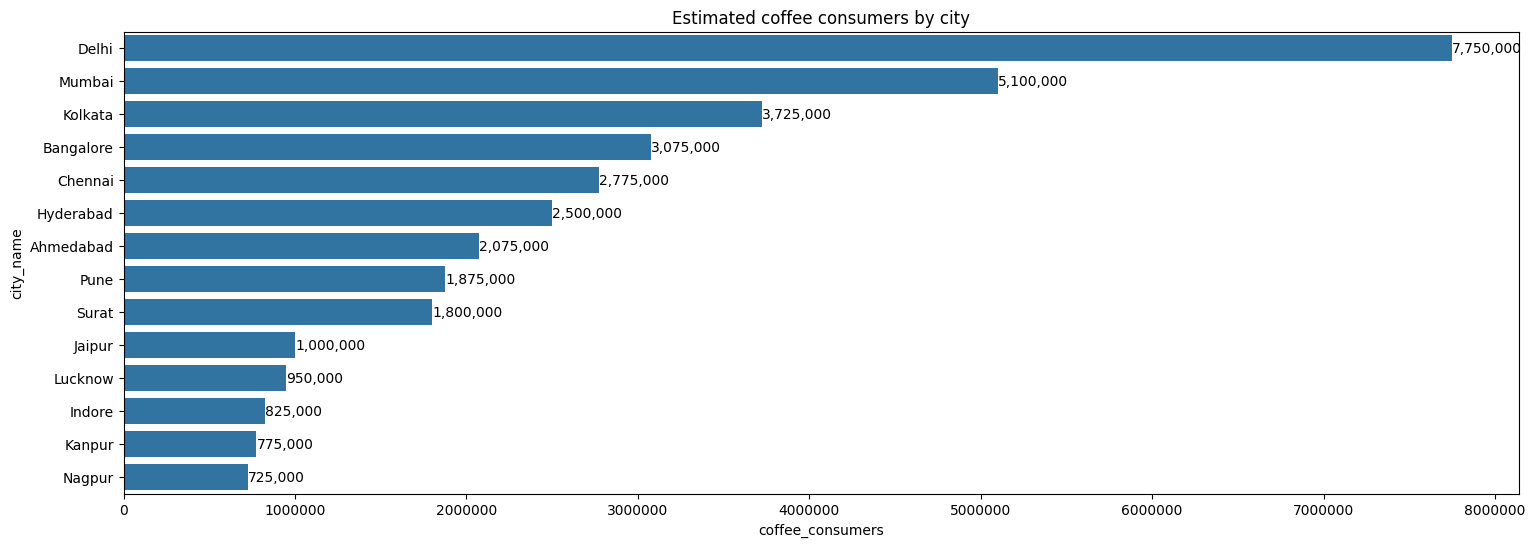

In [23]:
query = """SELECT city_name
            	,ROUND(population*0.25) AS coffee_consumers
            FROM city
            ORDER BY 2 DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["city_name", "coffee_consumers"])

plt.figure(figsize = (18,6))
desired_order = df.sort_values(by='coffee_consumers', ascending=False)['city_name'].tolist()
ax = sns.barplot(x = df["coffee_consumers"], y = df["city_name"], data = df, order=desired_order)
#plt.xticks(rotation = 90)
ax.ticklabel_format(style='plain', axis='x')
ax.bar_label(ax.containers[0], fmt='{:,.0f}')
plt.title("Estimated coffee consumers by city")
plt.show()

# What is the total revenue generated from coffee sales across all cities ?

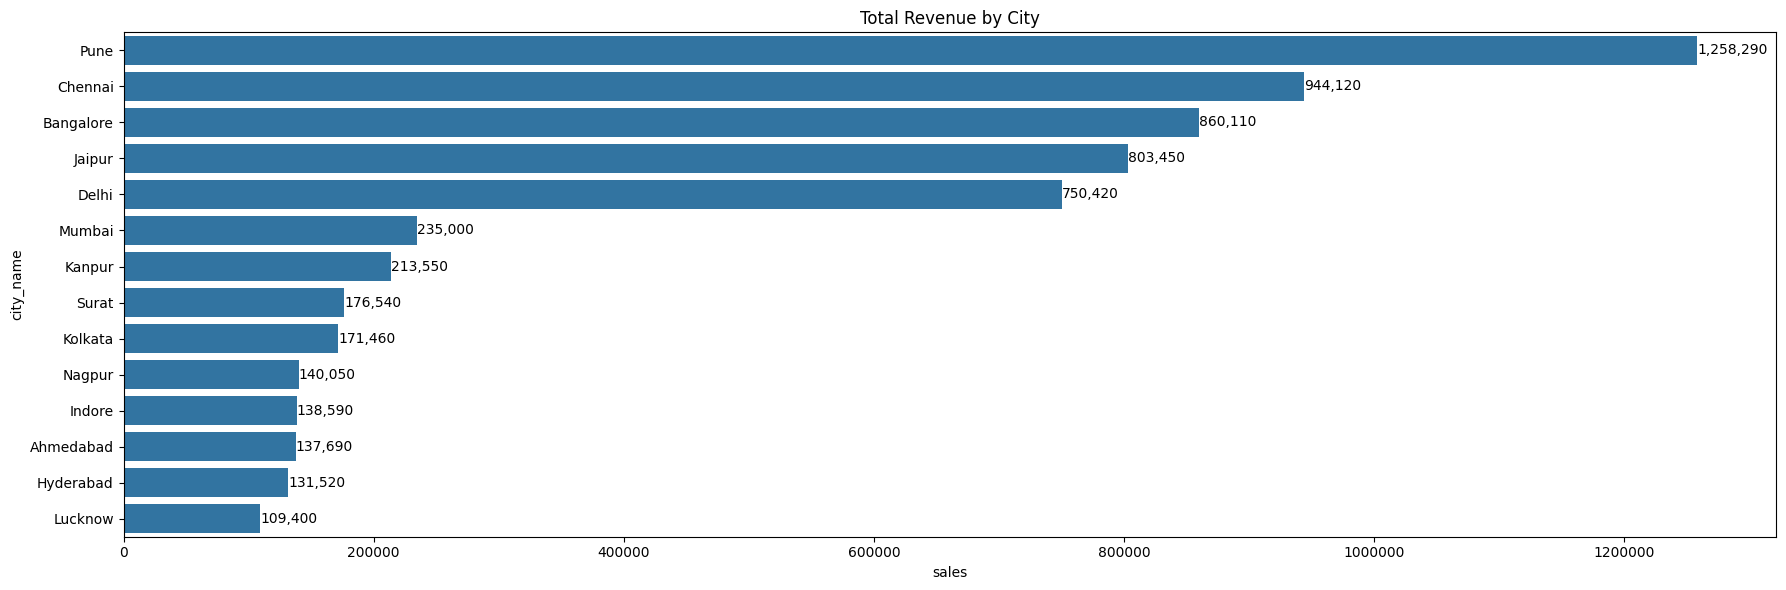

In [116]:
query = """SELECT city.city_name
            		,SUM(sales.total) AS sales
            FROM city
            INNER JOIN customers ON city.city_id = customers.city_id
            INNER JOIN sales ON customers.customer_id = sales.customer_id
            GROUP BY 1
            ORDER BY 2 DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["city_name", "sales"])
df.head()

"""plt.figure(figsize = (12,4))
ax = sns.barplot(x = df["city_name"], y = df["sales"], data = df)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Sales by City")
plt.show()
plt.figure(figsize = (12,4))
ax = plt.bar(df["city_name"], df["sales"])
plt.xticks(rotation = 45)
plt.xlabel("city_name")
plt.ylabel("sales")
plt.title("Total Sales by City")
ax.bar_label(ax.containers[0])
plt.show()"""

plt.figure(figsize = (18,6))
desired_order = df.sort_values(by='sales', ascending=False)['city_name'].tolist()
ax = sns.barplot(x = df["sales"], y = df["city_name"], data = df, order=desired_order)
#plt.xticks(rotation = 90)
ax.ticklabel_format(style='plain', axis='x')
ax.bar_label(ax.containers[0], fmt='{:,.0f}')
plt.title("Total Revenue by City")
plt.tight_layout()
plt.show()

# How many units of each coffee product have been sold?

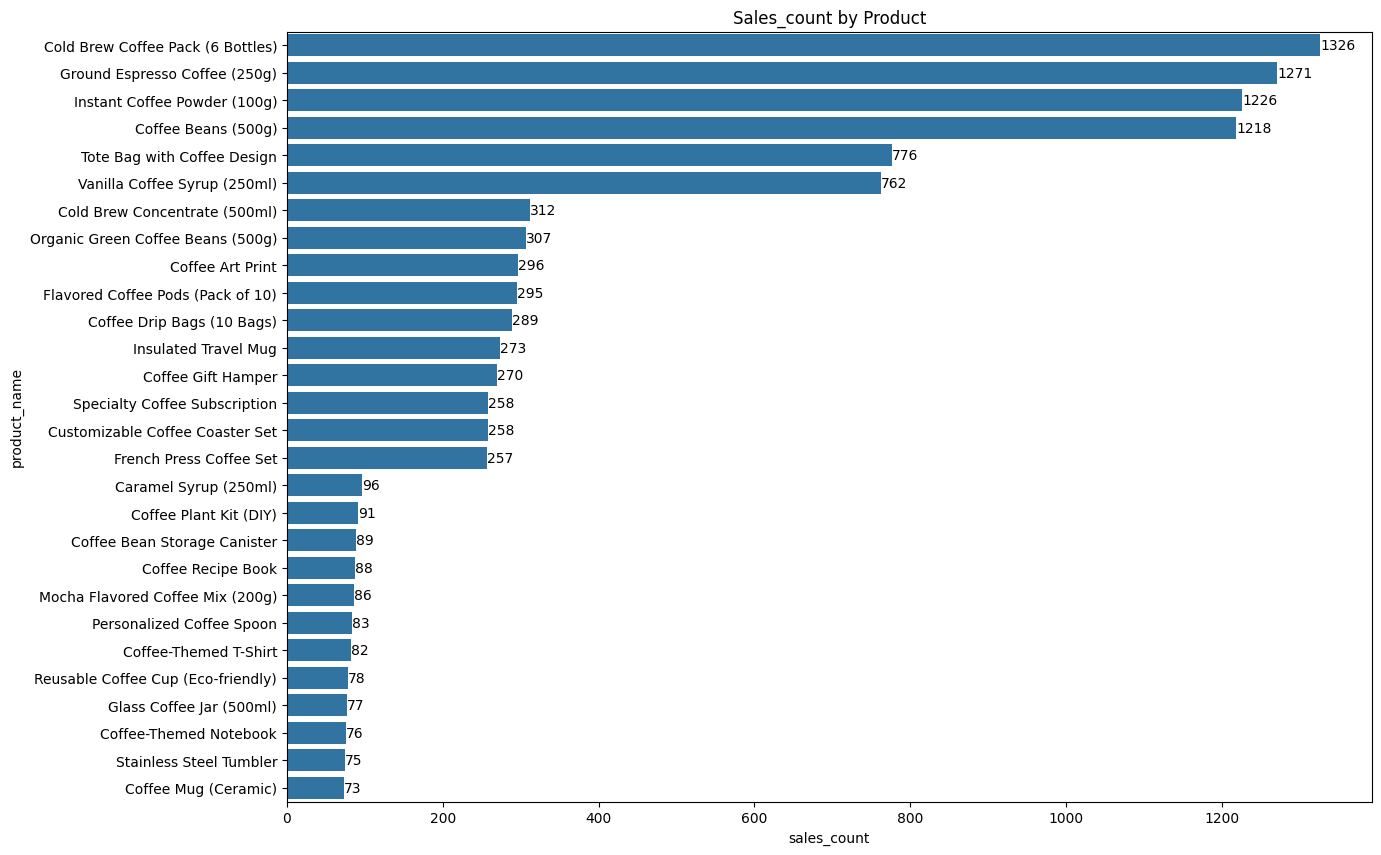

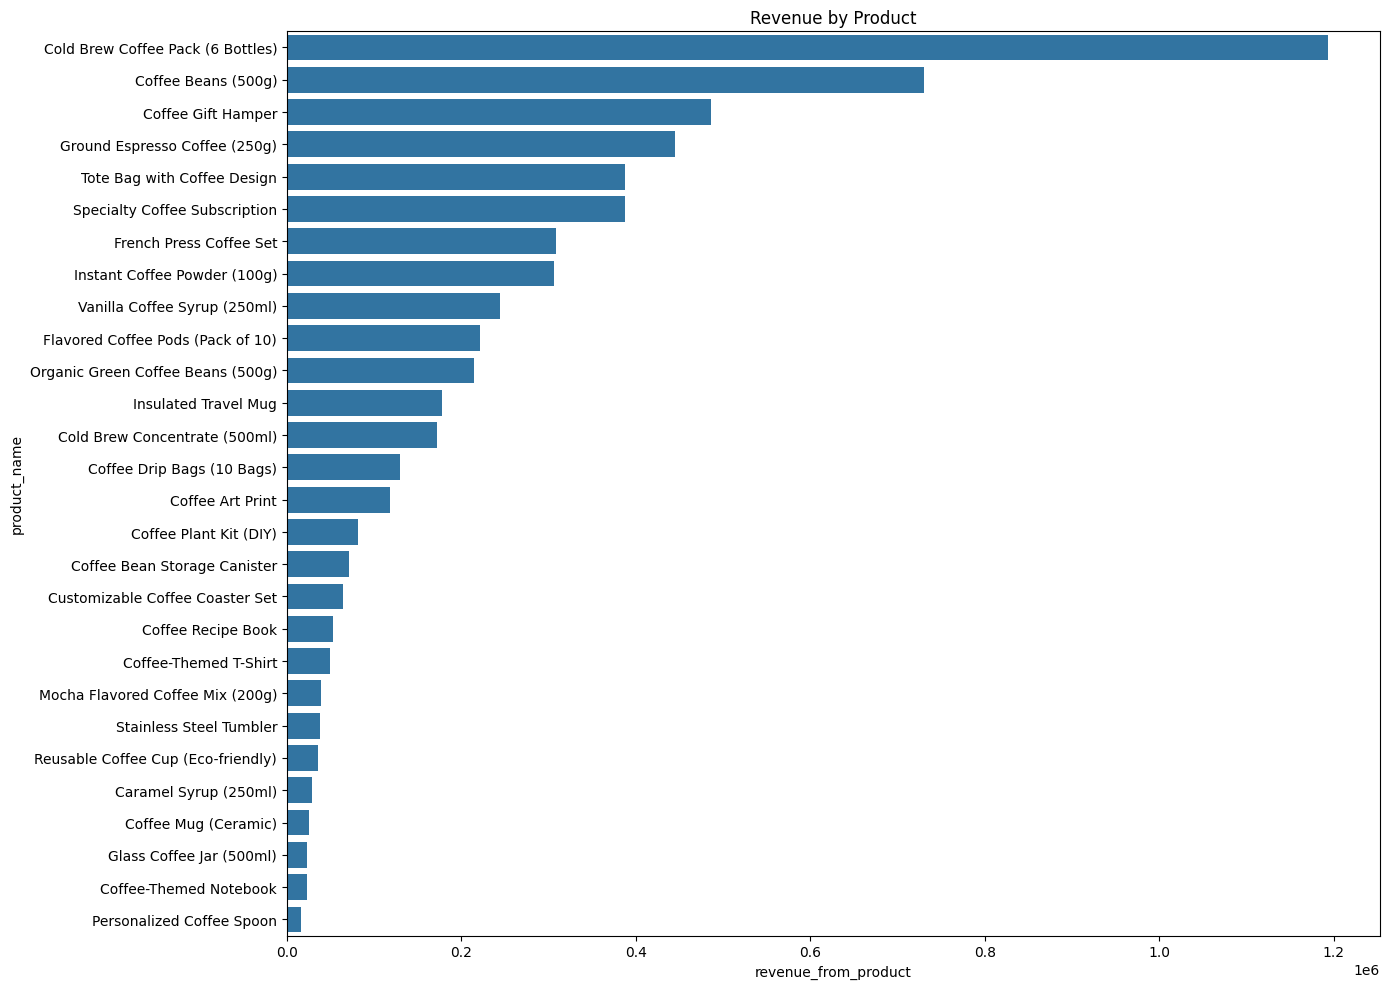

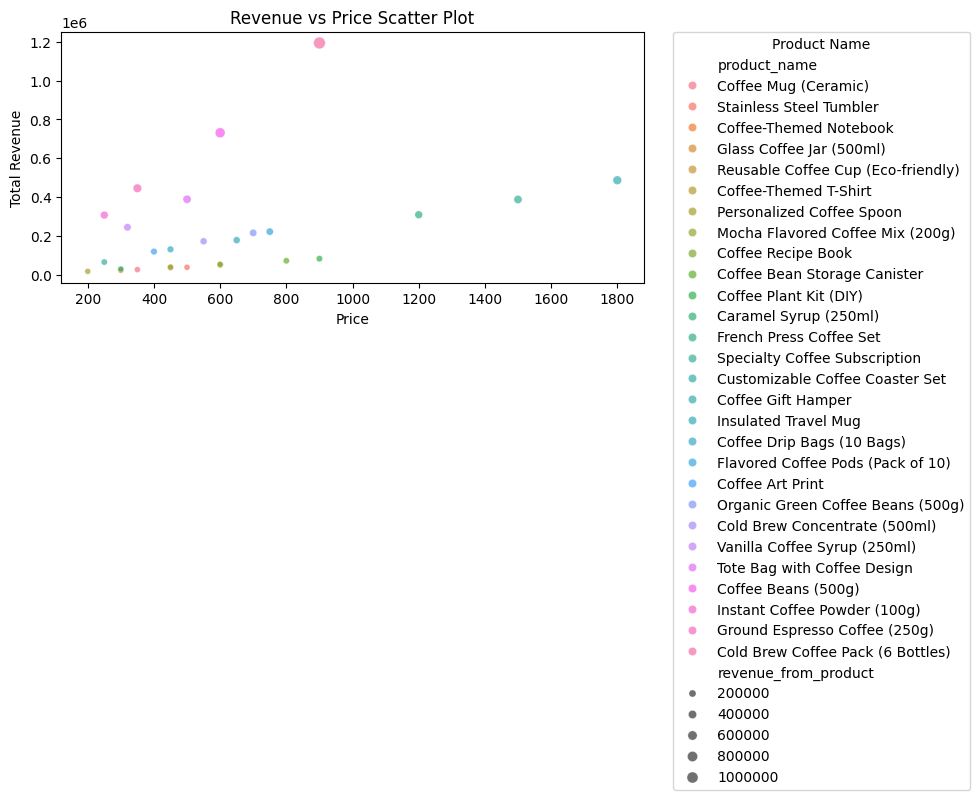

In [93]:
query = """SELECT products.product_id, product_name, price
            		,COUNT(sales.product_id)
                    ,SUM(sales.total)
            FROM products
            LEFT JOIN sales ON products.product_id = sales.product_id
            GROUP BY 1,2,3
            ORDER BY 4;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["product_id", "product_name", "price", "sales_count", "revenue_from_product"])
df.head()



plt.figure(figsize = (14,10))
desired_order = df.sort_values(by='sales_count', ascending=False)['product_name'].tolist()
ax = sns.barplot(x = df["sales_count"], y = df["product_name"], data = df, order=desired_order)
#plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Sales_count by Product")
plt.show()


plt.figure(figsize = (14,10))
desired_order = df.sort_values(by='revenue_from_product', ascending=False)['product_name'].tolist()
ax1 = sns.barplot(x = df["revenue_from_product"], y = df["product_name"], data = df, order=desired_order)
#plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Revenue by Product")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(data=df, x=df['price'].astype(float), y=df['revenue_from_product'].astype(float), hue=df['product_name'], size=df['revenue_from_product'].astype(float), alpha=0.7)
plt.legend(
    title='Product Name',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ##ncol=2,
    borderaxespad=0.
)
plt.title('Revenue vs Price Scatter Plot')
plt.xlabel('Price')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

# What is the average sales amount per customer in each city?

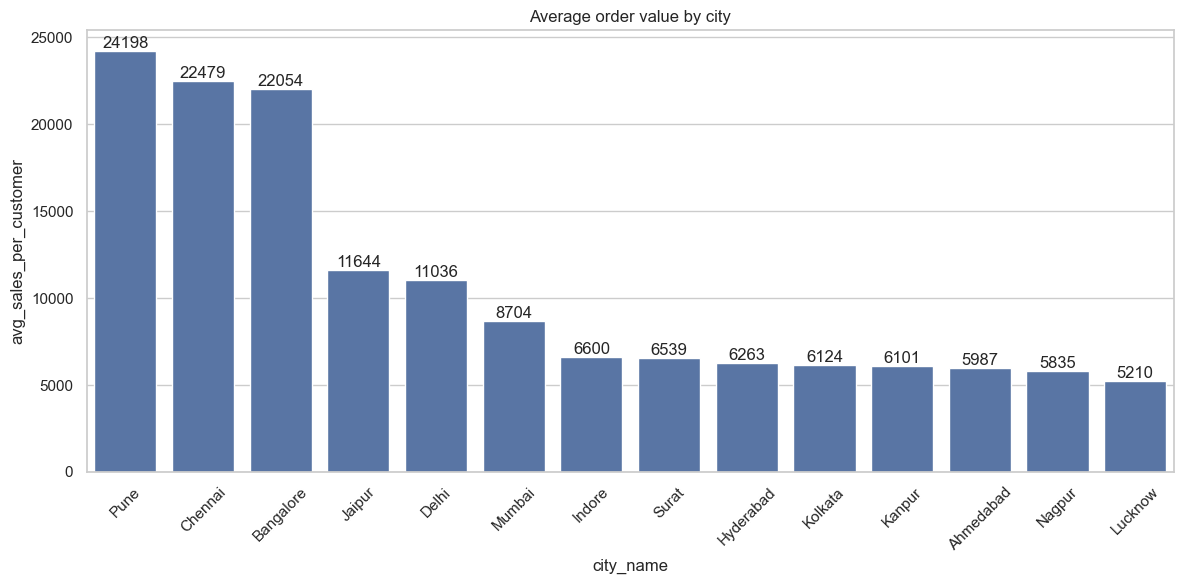

In [139]:
query = """SELECT city.city_name
                    ,ROUND((SUM(sales.total))/COUNT(DISTINCT sales.customer_id)) AS avg_sales_per_customer
            FROM customers
            JOIN sales ON customers.customer_id = sales.customer_id
            JOIN city ON city.city_id = customers.city_id
            GROUP BY 1
            ORDER BY 2 DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["city_name", "avg_sales_per_customer"])
df.head()

plt.figure(figsize = (12,6))
ax = sns.barplot(x = df["city_name"], y = df["avg_sales_per_customer"], data = df)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Average order value by city")
plt.tight_layout()
plt.show()

# Current customers per city.

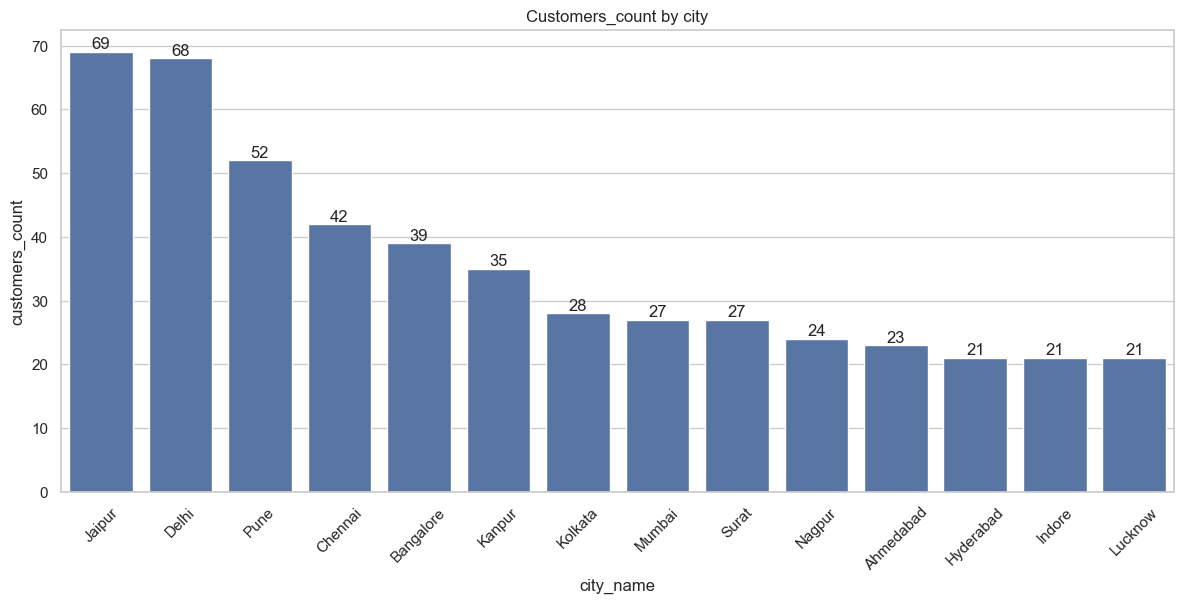

In [143]:
query = """SELECT city.city_name
            ,COUNT(DISTINCT customers.customer_id) as current_customers
            FROM city
            JOIN customers ON city.city_id = customers.city_id
            GROUP BY 1
            ORDER BY 2 DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["city_name", "customers_count"])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x = df["city_name"], y = df["customers_count"], data = df)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.title("Customers_count by city")

plt.show()

# Total sales over time

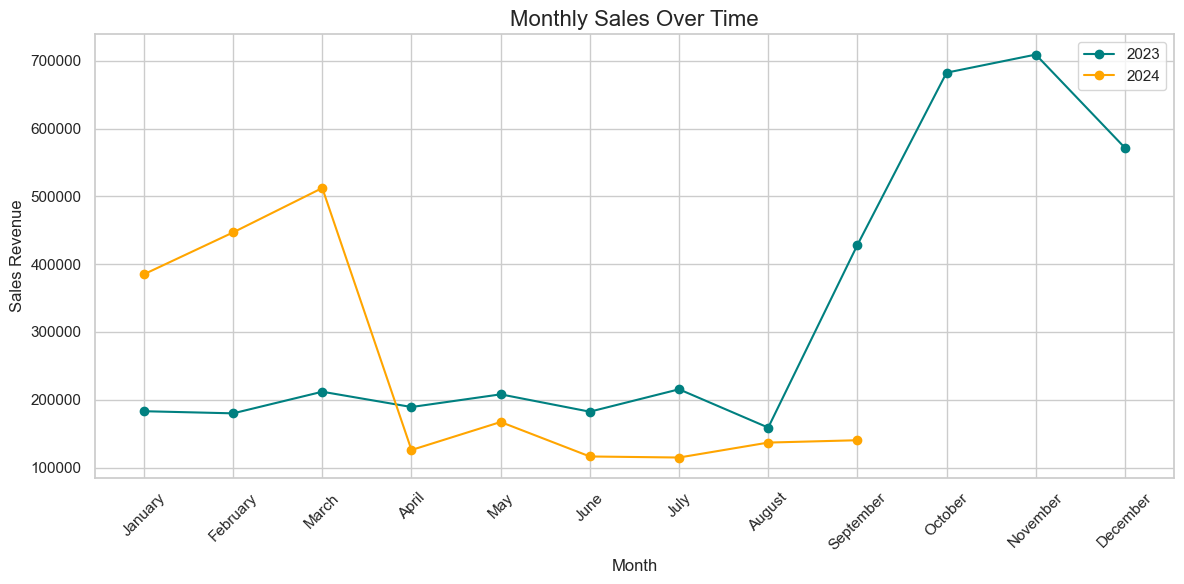

In [132]:
query = """SELECT
              YEAR(sale_date) AS 'year',
              MONTH(sale_date) AS 'month',
              MONTHNAME(sale_date) AS 'month_name',
              SUM(total) AS monthly_sales
            FROM sales
            GROUP BY 1,2,3
            ORDER BY 1,2;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["year", "month", "month_name", "monthly_sales"])
df

pivot_df = df.pivot(index="month", columns="year", values="monthly_sales")
pivot_df.index = df.drop_duplicates("month")["month_name"].values  # Use month names

plt.figure(figsize=(12, 6))

for i, year in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[year], marker='o', color=colors[i], label=str(year))


plt.title("Monthly Sales Over Time", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Sales Revenue")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Customer Retention

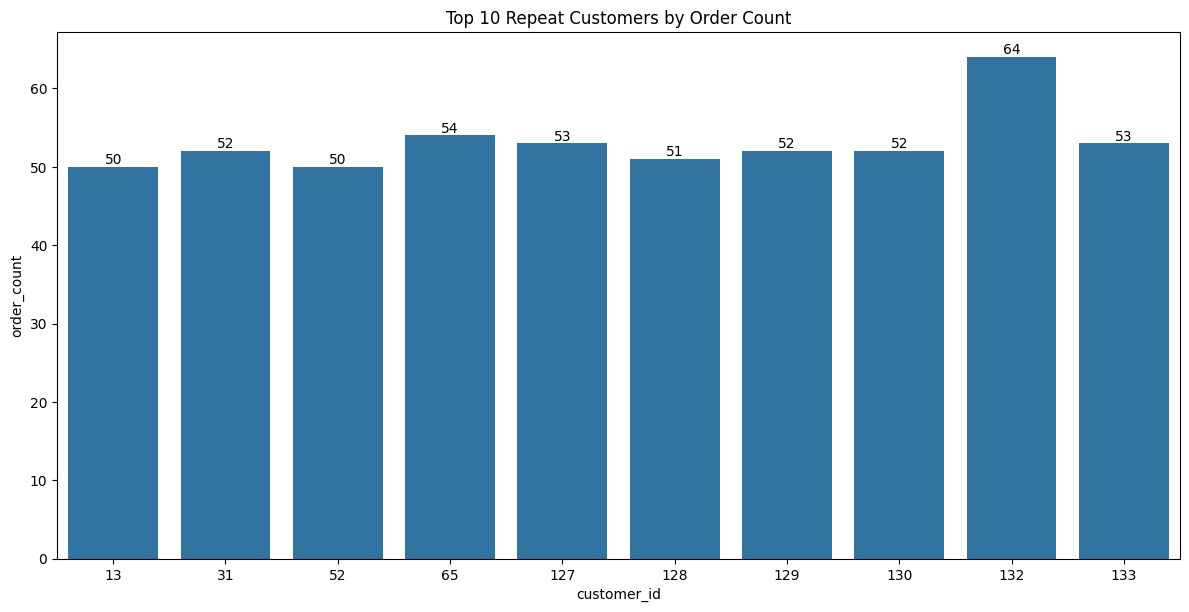

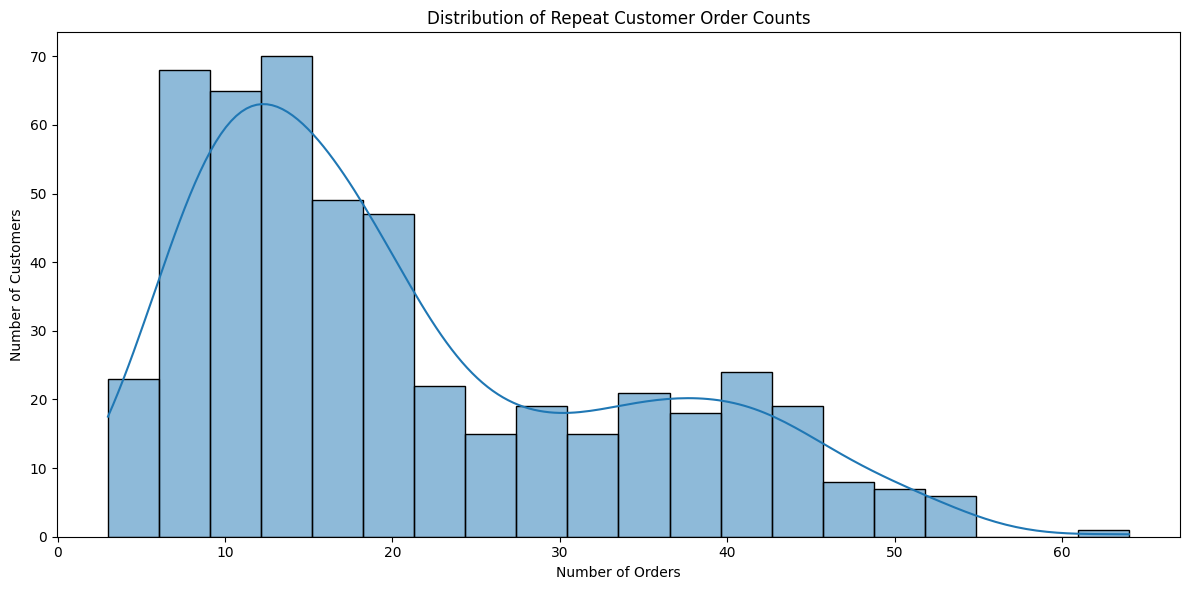

In [58]:
query = """SELECT c.customer_id
            		,COUNT(s.sale_id) AS order_count
            FROM customers c
            JOIN sales s
            ON c.customer_id = s.customer_id
            GROUP BY 1
            HAVING COUNT(s.sale_id) > 1
            ORDER BY 2 DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["customer_id", "order_count"])
top_n = df.head(10)
top_n

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_n, x="customer_id", y="order_count")
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.title("Top 10 Repeat Customers by Order Count")

plt.show()

plt.figure(figsize=(12, 6))
ax1 = sns.histplot(df['order_count'], bins=20, kde=True)
plt.title("Distribution of Repeat Customer Order Counts")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

# Spend Per Customer (Distribution)

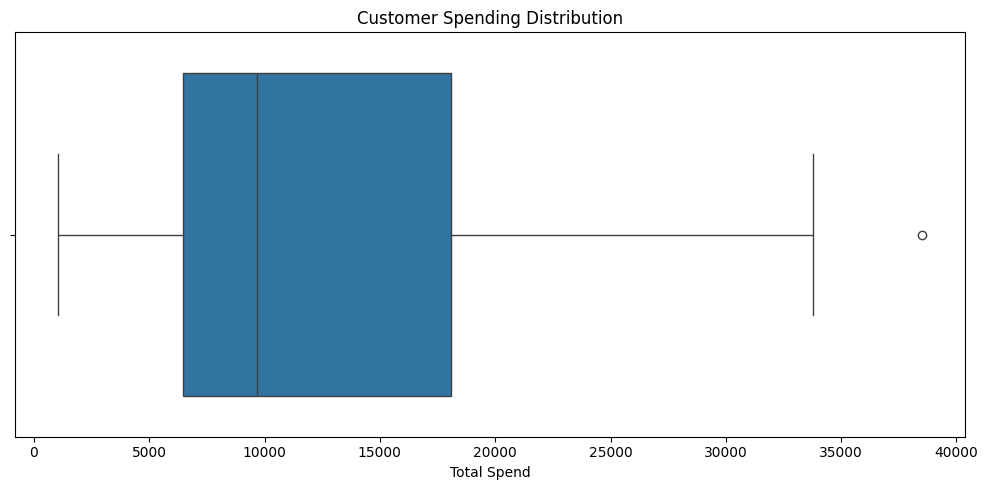

In [66]:
query = """SELECT c.customer_id
            		,SUM(s.total) AS total_spend
            FROM customers c
            JOIN sales s
            ON c.customer_id = s.customer_id
            GROUP BY 1
            ORDER BY 2 DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["customer_id", "total_spend"])
df

plt.figure(figsize=(10,5))
ax = sns.boxplot(x='total_spend', data=df)
plt.title('Customer Spending Distribution')
plt.xlabel('Total Spend')
plt.tight_layout()
plt.show()

# top 3 selling product by city

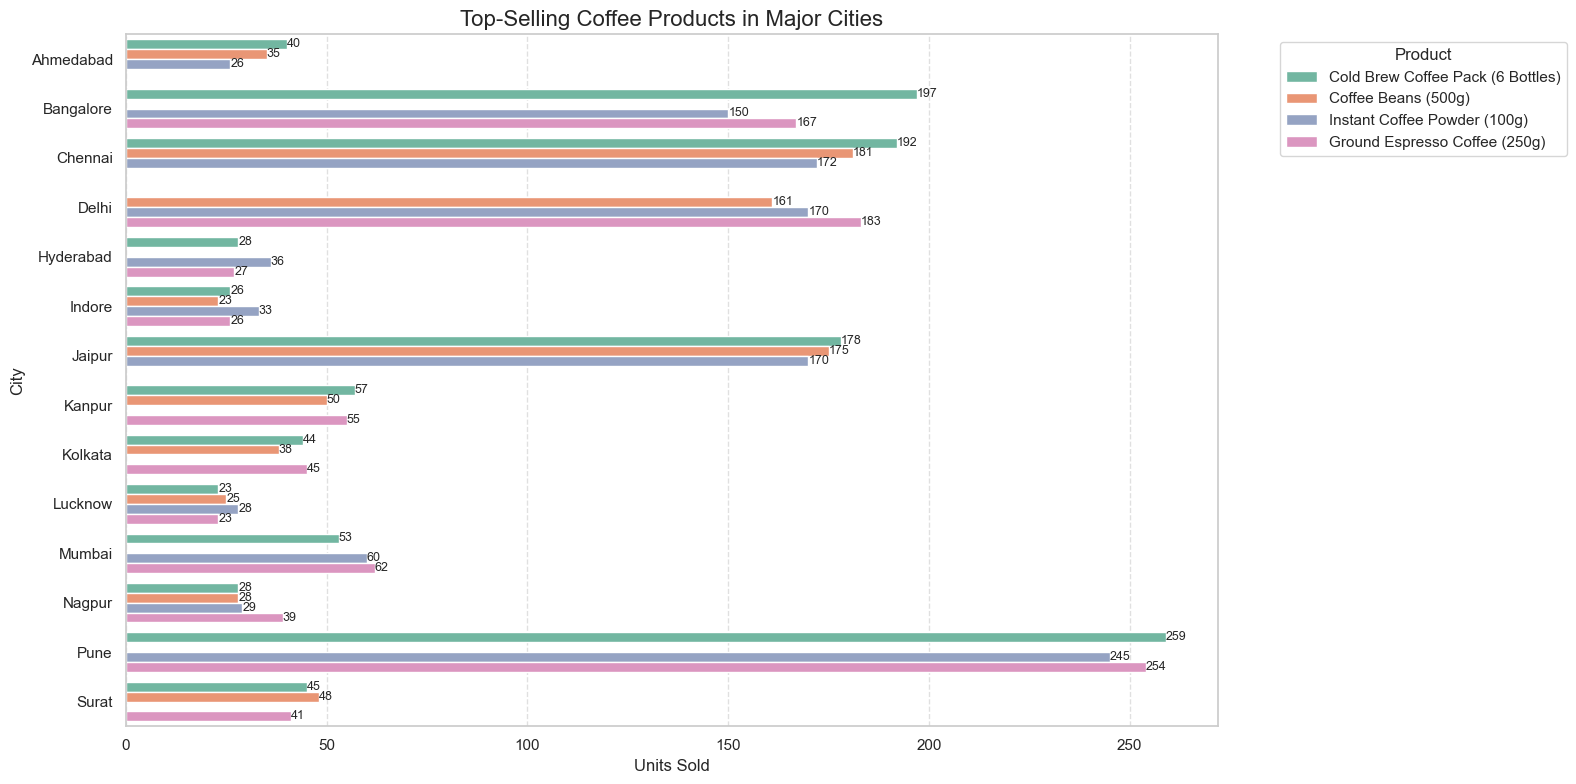

In [130]:
from warnings import filterwarnings
filterwarnings('ignore')


query = """WITH revenue AS (SELECT c.city_name
                            		,p.product_name
                            		,COUNT(s.sale_id) total_count
                                    ,dense_rank() over(PARTITION BY c.city_name ORDER BY COUNT(s.sale_id) DESC) AS selling_rank
                            FROM sales s
                            JOIN products p ON s.product_id = p.product_id
                            JOIN customers cu on s.customer_id = cu.customer_id
                            JOIN city c ON cu.city_id = c.city_id
                            GROUP BY 2,1)
            SELECT * FROM revenue WHERE selling_rank <= 3;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["city_name", "product_name", "total_count", "selling_rank"])

palette = sns.color_palette("Set2")

plt.figure(figsize=(16, 8))
ax = sns.barplot(
    x='total_count',
    y='city_name',
    hue='product_name',
    data=df,
    palette=palette
)

plt.title('Top-Selling Coffee Products in Major Cities', fontsize=16)
plt.xlabel('Units Sold', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)

plt.show()

# Customer segmentation by city

Text(0.5, 1.0, 'Repeat Customers by City')

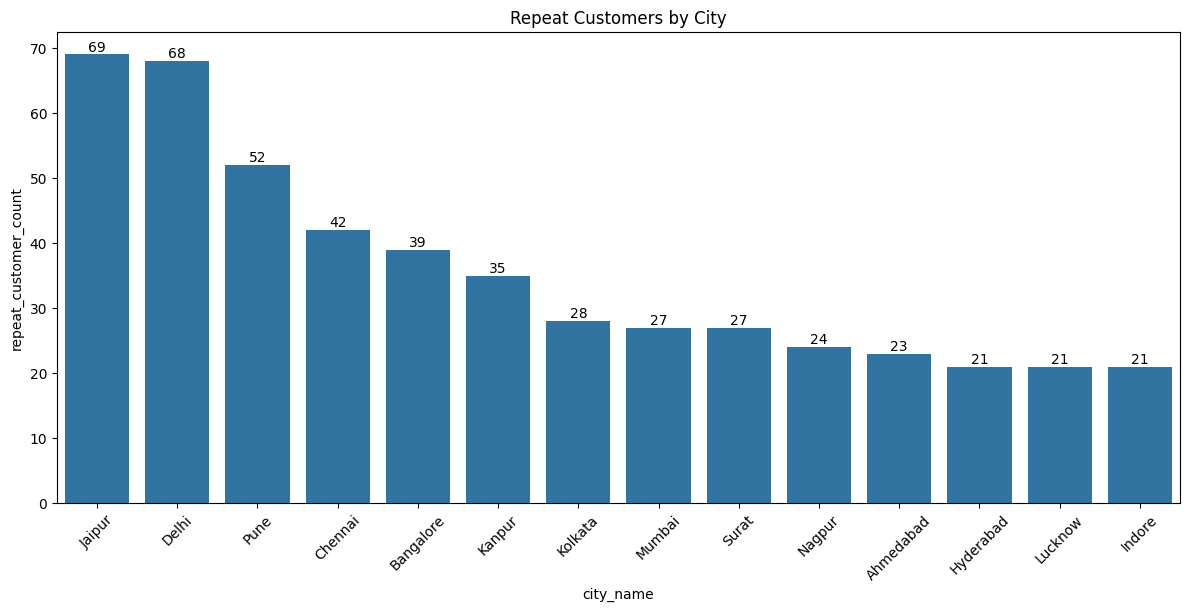

In [113]:
query = """WITH repeat_customer AS (
                                    SELECT c.customer_id,
                                           COUNT(s.sale_id) AS order_count
                                    FROM customers c
                                    JOIN sales s ON c.customer_id = s.customer_id
                                    GROUP BY c.customer_id
                                    HAVING COUNT(s.sale_id) > 1
                                ),
            city_info AS (
                SELECT cu.customer_id,
                       ci.city_name
                FROM customers cu
                JOIN city ci ON cu.city_id = ci.city_id
            )
            SELECT ci.city_name,
                   COUNT(rc.customer_id) AS repeat_customer_count
            FROM repeat_customer rc
            JOIN city_info ci ON rc.customer_id = ci.customer_id
            GROUP BY ci.city_name
            ORDER BY repeat_customer_count DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["city_name", "repeat_customer_count"])
df

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x="city_name", y="repeat_customer_count")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title("Repeat Customers by City")

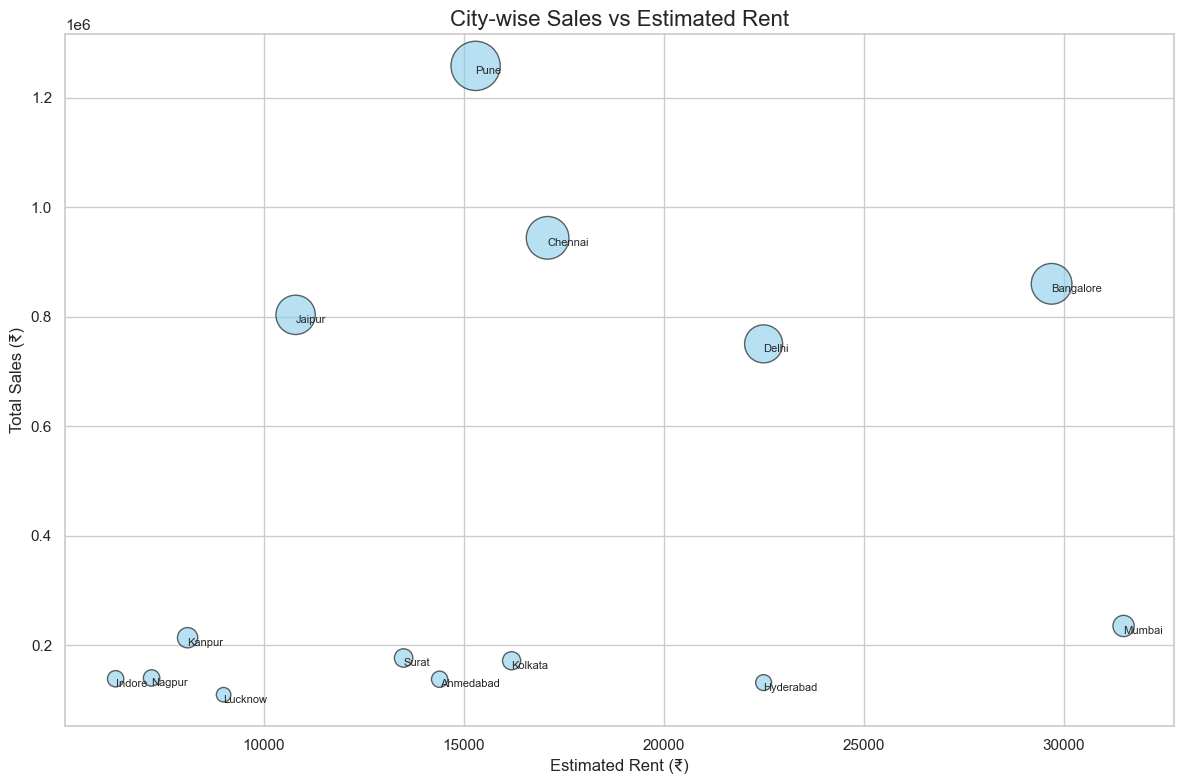

In [144]:
query = """SELECT city.city_name
					,city.estimated_rent
            		,SUM(sales.total) AS sales
            FROM city
            INNER JOIN customers ON city.city_id = customers.city_id
            INNER JOIN sales ON customers.customer_id = sales.customer_id
            GROUP BY 1,2
            ORDER BY 3 DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["city_name", "estimated_rent", "sales"])
df

bubble_size = df['sales'].astype(float) / 1000  # Adjust this divisor as needed

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Bubble chart (scatter with size)
scatter = plt.scatter(
    x=df['estimated_rent'].astype(float),
    y=df['sales'].astype(float),
    s=bubble_size,  # size of bubbles
    alpha=0.6,
    edgecolors="black",
    c='skyblue'
)

# Add city labels to each bubble
for i in range(len(df)):
    plt.text(
        df['estimated_rent'][i],
        df['sales'][i],
        df['city_name'][i],
        fontsize=8,
        ha='left',
        va='top'
    )

plt.title('City-wise Sales vs Estimated Rent', fontsize=16)
plt.xlabel('Estimated Rent (₹)', fontsize=12)
plt.ylabel('Total Sales (₹)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

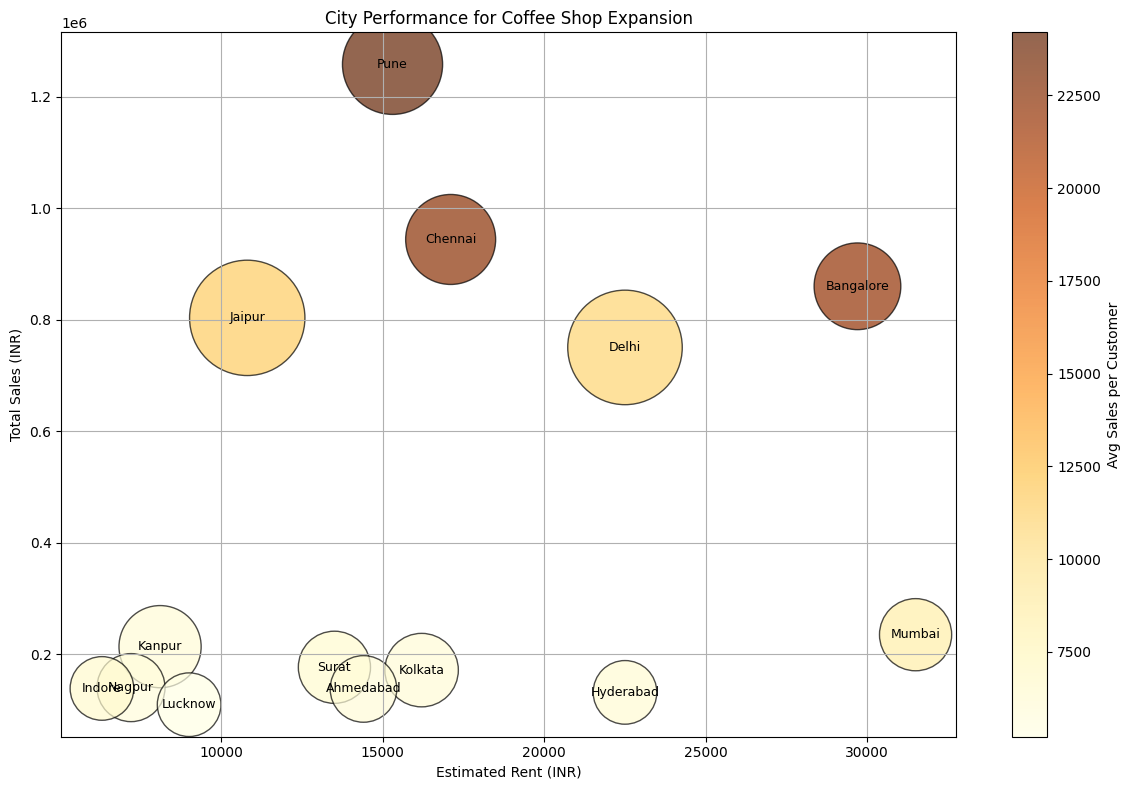

In [7]:
query = """WITH t1 AS(SELECT city.city_name
					,city.city_id
					,city.estimated_rent
					,(city.population*0.25) as estimated_coffee_consumers
            		,SUM(sales.total) AS total_sales
            FROM city
            INNER JOIN customers ON city.city_id = customers.city_id
            INNER JOIN sales ON customers.customer_id = sales.customer_id
            GROUP BY 1,2,3,4),
			
t2 AS (SELECT city.city_name
			,city.city_id
            ,COUNT(DISTINCT customers.customer_id) as current_customers
            FROM city
            JOIN customers ON city.city_id = customers.city_id
            GROUP BY 1,2),
			
t3 AS (SELECT city.city_name
					,city.city_id
                    ,ROUND((SUM(sales.total))/COUNT(DISTINCT sales.customer_id)) AS avg_sales_per_customer
            FROM customers
            JOIN sales ON customers.customer_id = sales.customer_id
            JOIN city ON city.city_id = customers.city_id
            GROUP BY 1,2)

SELECT t1.city_name
		,t1.estimated_rent
		,t1.estimated_coffee_consumers
		,t1.total_sales
		,t2.current_customers
		,t3.avg_sales_per_customer
FROM t1
JOIN t2 ON t1.city_id = t2.city_id
JOIN t3 ON t1.city_id = t3.city_id
ORDER BY 5 DESC,4 DESC,2 ASC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["city_name", "estimated_rent", "estimated_coffee_consumers", "total_sales", "current_customers", "avg_sales_per_customer"])
df

# Step 2: Plot Bubble Chart
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    x=df['estimated_rent'].astype(float),
    y=df['total_sales'].astype(float),
    s=df['current_customers'].astype(float)*100,  # bubble size
    c=df['avg_sales_per_customer'].astype(float),            # bubble color
    cmap='YlOrBr',
    alpha=0.7,
    edgecolors='black',
    linewidths=1
)

# Step 3: Add City Labels
for i in range(df.shape[0]):
    plt.text(
        df['estimated_rent'][i],
        df['total_sales'][i],
        df['city_name'][i],
        fontsize=9,
        ha='center',
        va='center'
    )

# Step 4: Customize Axes and Add Colorbar
plt.xlabel("Estimated Rent (INR)")
plt.ylabel("Total Sales (INR)")
plt.title("City Performance for Coffee Shop Expansion")
cbar = plt.colorbar(scatter)
cbar.set_label("Avg Sales per Customer")

plt.grid(True)
plt.tight_layout()
plt.show()